# Dataset exploration

In [5]:
import os
import json

get_data_from_dir = lambda dir: [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.json')]

locations = ["mandrac_imgs1", "mandrac_imgs2", "bistrina_imgs"]
datasets = [get_data_from_dir(f"data/{loc}") for loc in locations]

# they did train – mandrac1, val – mandrac2, test – bistrina

# To form the training,
# validation and test sets, we first create collections A, B and
# C by sampling the videos from the first, second and third
# acquisition, respectively. From approximately 15 minutes
# of a video, we sample only 162 images to ensure there
# are no duplicate images. Also, to make the dataset more
# challenging, we use only collection A for training. The
# validation and test sets are formed from collections B and C (see Fig. 3.)

datasets_positives = []
for dataset in datasets:
    dataset_positives = 0
    for img_json in dataset:
        # json_path = os.path.splitext(datasets[0][0])[0]  + ".json"
        with open(img_json) as json_file:
            data = json.load(json_file)
            for shape in data["shapes"]:
                if shape["label"] == "trash":
                    dataset_positives += 1
                else:
                    print("negative example found in", img_json)
    print(dataset_positives)
        
    datasets_positives.append(dataset_positives)

all = sum([len(d) for d in datasets])
for i in range(len(locations)):
    print(f"{locations[i]}: {len(datasets[i])} images ({len(datasets[i])/all*100:.2f}%), {datasets_positives[i]} positive examples")

# no negative examples in the dataset

34
101
119
mandrac_imgs1: 34 images (19.32%), 34 positive examples
mandrac_imgs2: 62 images (35.23%), 101 positive examples
bistrina_imgs: 80 images (45.45%), 119 positive examples


In [6]:
import os
import json
from collections import Counter

get_data_from_dir = lambda dir: [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.json')]

locations = ["training", "validation", "test"]
datasets = [get_data_from_dir(f"data/Dataset/{loc}") for loc in locations]

datasets_positives = []
dimentions = []
for dataset in datasets:
    dataset_positives = 0
    for img_json in dataset:
        # json_path = os.path.splitext(datasets[0][0])[0]  + ".json"
        with open(img_json) as json_file:
            data = json.load(json_file)
            for shape in data["shapes"]:
                if shape["label"] == "trash":
                    dataset_positives += 1
                else:
                    print("negative example found in", img_json)
            dimentions.append((data["imageHeight"], data["imageWidth"]))
        
    datasets_positives.append(dataset_positives)

all = sum([len(d) for d in datasets])
for i in range(len(locations)):
    print(f"{locations[i]}: {len(datasets[i])} images ({len(datasets[i])/all*100:.2f}%), {datasets_positives[i]} positive examples")

Counter(dimentions)
# no negative examples in the dataset
# all the same dimentions

training: 20 images (12.35%), 20 positive examples
validation: 20 images (12.35%), 36 positive examples
test: 122 images (75.31%), 184 positive examples


Counter({(1080, 1920): 162})

# Crafting features

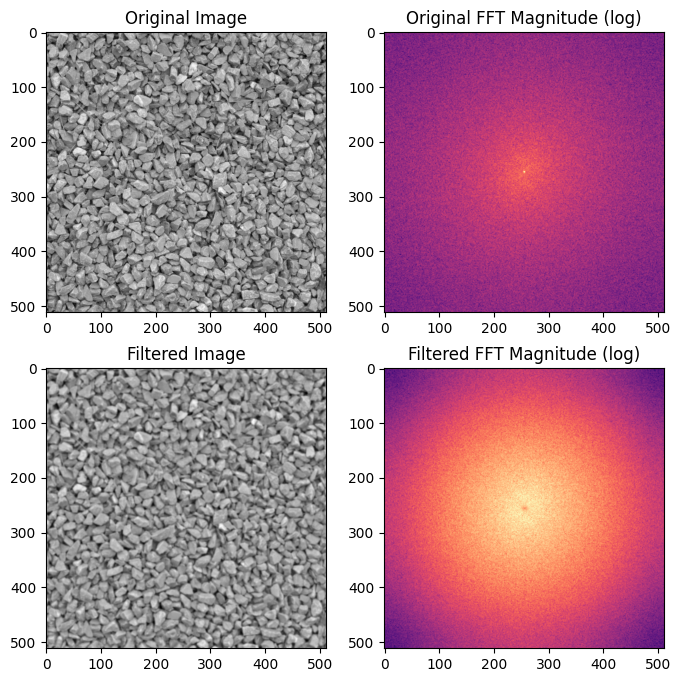

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift

image = gravel()
wimage = image * window('hann', image.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(image, 1, 12)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

del filtered_image, filtered_wimage, im_f_mag, fim_f_mag


Diffrence of gausian 
- applying gussian blure with some defition to blurred image 
- the same with some scaller for difation 
- dwa zblurowane zdjęcia z czego jedno jest bardziej zblurowane od grugiego 
- odejmujemy te dwa zdjęcia i mamy edge lines 
- (potem można binaryzacje z jakimś treschold)
- czyli wykrywa miejsca o wysokim kontraście które z reguły są wierzchołami/liniami 
- problem z tym że też wykrywa noise 

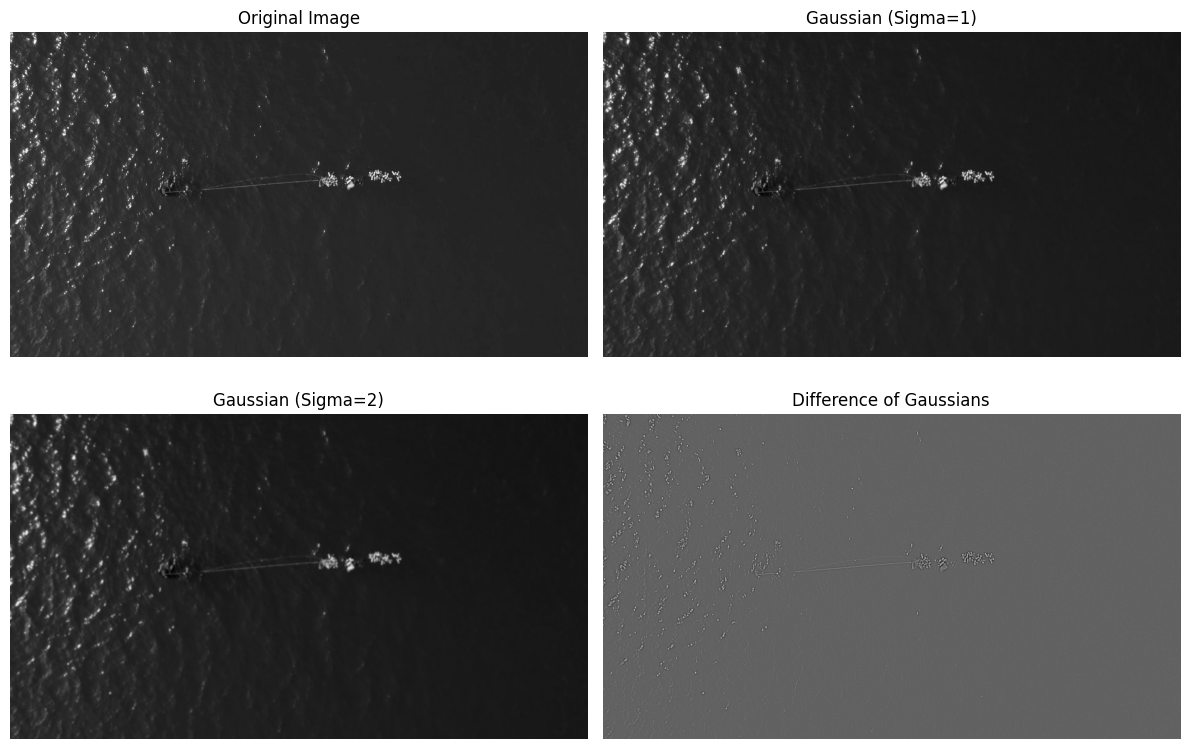

In [8]:
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.filters import gaussian, difference_of_gaussians

image = io.imread('data/bistrina_imgs/record4_102_19.JPG')

gray_image = color.rgb2gray(image)

# Step 3: Convert the image to float format
float_image = img_as_float(gray_image)

# Step 4: Apply Gaussian blurring with different sigma values
sigma1 = 1  # Sigma value for the first Gaussian blur
sigma2 = 2  # Sigma value for the second Gaussian blur
gaussian1 = gaussian(float_image, sigma=sigma1)
gaussian2 = gaussian(float_image, sigma=sigma2)

# Step 5: Compute the difference of Gaussians
dog_image = difference_of_gaussians(float_image, sigma1, sigma2)

# Step 6: Display the original image, Gaussian blurred images, and the difference of Gaussians
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Changed figsize to accommodate two rows
ax = axes.ravel()

ax[0].imshow(float_image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(gaussian1, cmap='gray')
ax[1].set_title('Gaussian (Sigma={})'.format(sigma1))

ax[2].imshow(gaussian2, cmap='gray')
ax[2].set_title('Gaussian (Sigma={})'.format(sigma2))

ax[3].imshow(dog_image, cmap='gray')
ax[3].set_title('Difference of Gaussians')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

del float_image, gaussian1, gaussian2, dog_image


# Find ROIs

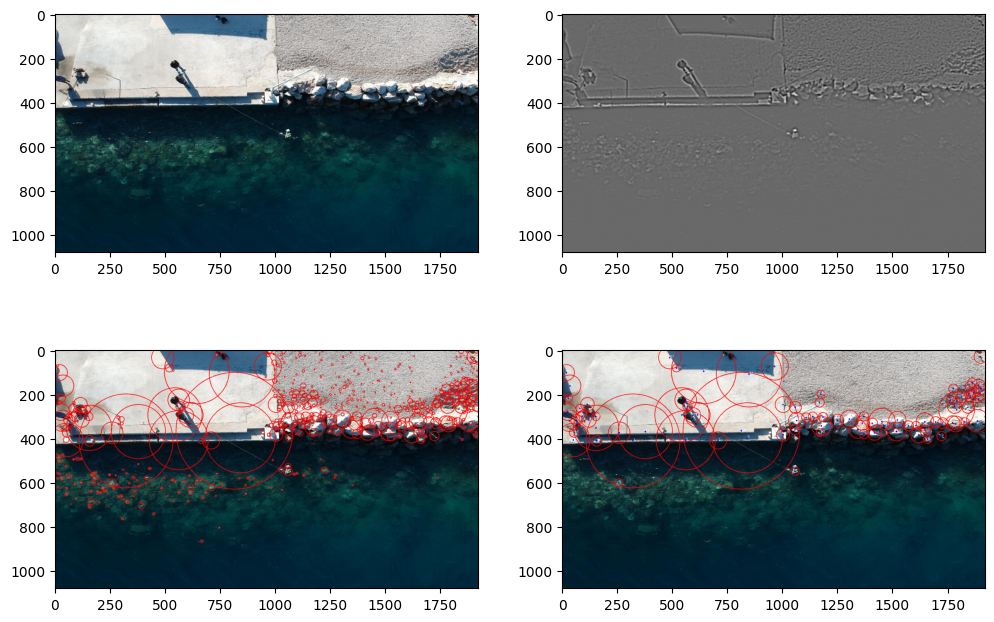

In [9]:
import os
import cv2
from model import apply_dog, find_rois, draw_circles

path = "data/Dataset/training/"
filename = "train_image11"
image = io.imread(path + filename + ".JPG")
visualize = True

with open(path + filename + ".json") as json_file:
    data = json.load(json_file)
    altitude = int(os.path.splitext(data["imagePath"])[0].split('_')[-1])

mask, dog_image = apply_dog(image, altitude)
rois, image_rois = find_rois(image, mask, visualize=visualize)
rois = [circle for circle in rois if np.pi*circle[2]**2 > 1000] # filter rois by surface
image_filtered_rois = draw_circles(image.copy(), rois, (255, 0, 0))


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Changed figsize to accommodate two rows
ax = axes.ravel()
ax[0].imshow(image)
ax[1].imshow(dog_image, cmap='gray')
ax[2].imshow(image_rois)
ax[3].imshow(image_filtered_rois)
plt.show()


del dog_image, mask, image_rois


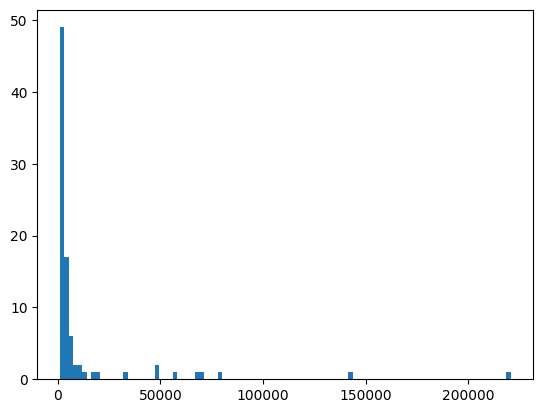

In [10]:
areas = [np.pi*circle[2]**2 for circle in rois if circle]

plt.hist([area for area in areas if area > 30], bins=100);

# Merge ROIs

In [11]:
old_circles = rois.copy()

In [12]:
circles = old_circles.copy()
len(circles)

88

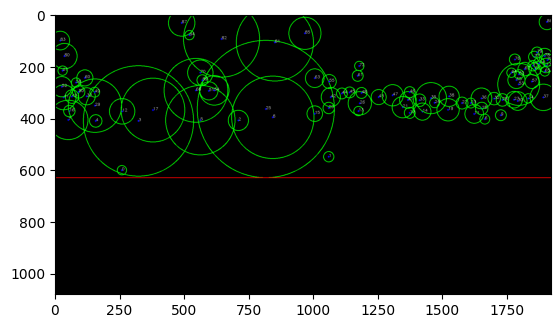

In [14]:
import cv2
import matplotlib.pyplot as plt
from model import merge_rois_to_rectangle


# Initialize the list of circles
# image_small = np.zeros((300, 400, 3), dtype=np.uint8)
# circles = [
#     (130, 140, 20),
#     (150, 150, 30),
#     (150, 175, 25),
#     (300, 100, 35),
#     (310, 110, 10)
# ]

rectangles, image_merged_rectangles = merge_rois_to_rectangle(circles, image, visualize=True)
plt.imshow(image_merged_rectangles);
plt.show()

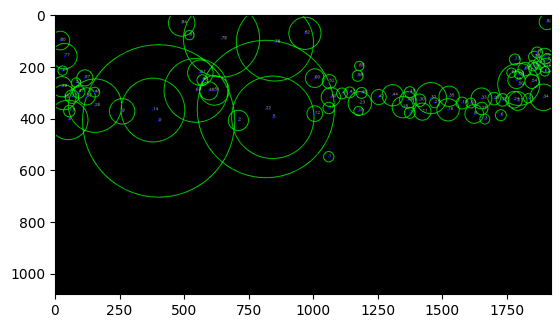

merge  0 2 (400, 412, 294) (708, 410, 39)


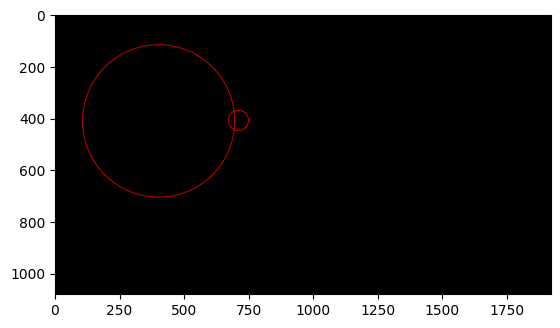

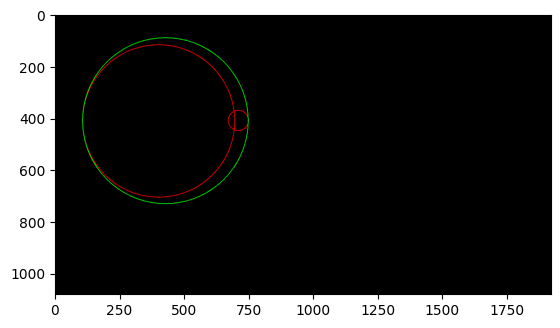

merge  0 3 (426, 411, 320) (51, 408, 76)


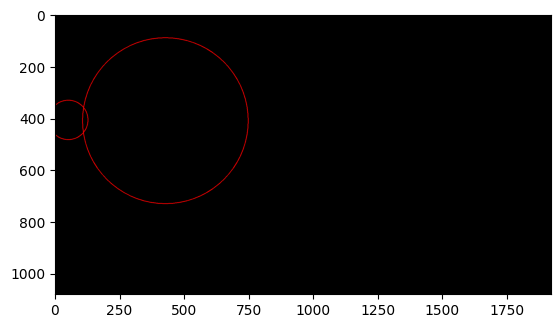

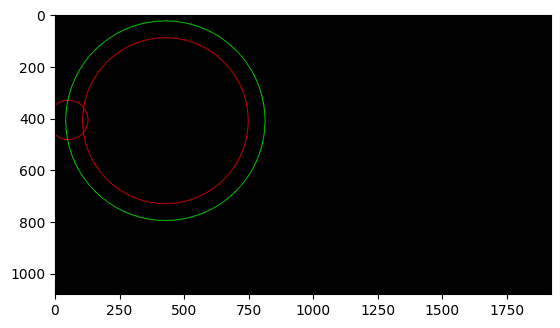

merge  0 3 (426, 411, 385) (841, 398, 159)


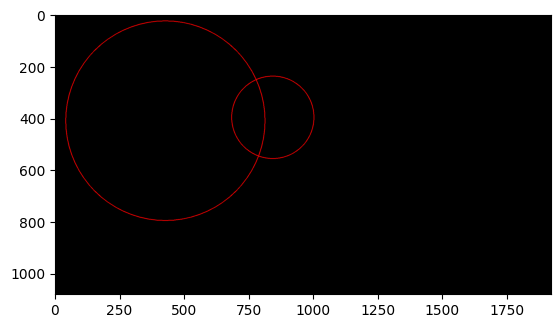

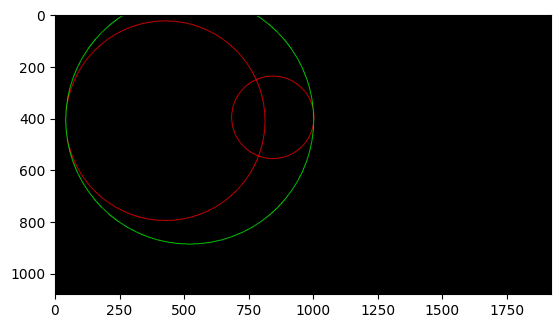

merge  0 6 (520, 408, 479) (259, 375, 49)


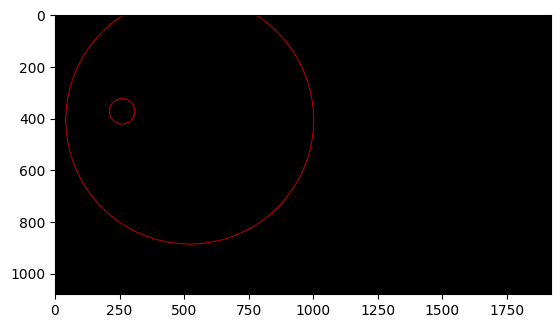

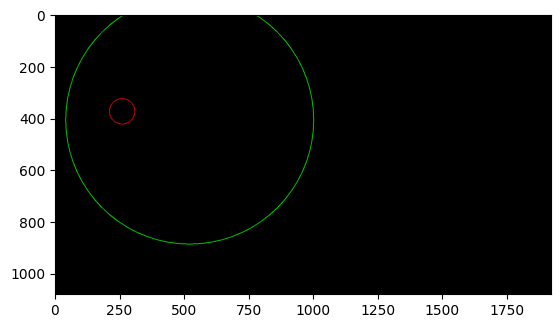

merge  0 8 (520, 408, 479) (1003, 384, 30)


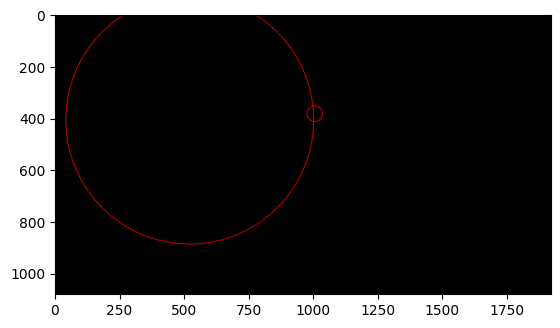

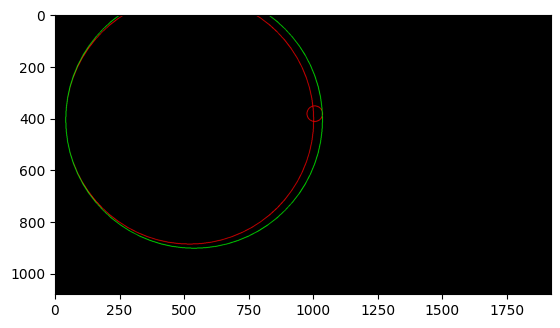

merge  0 8 (537, 407, 496) (55, 374, 22)


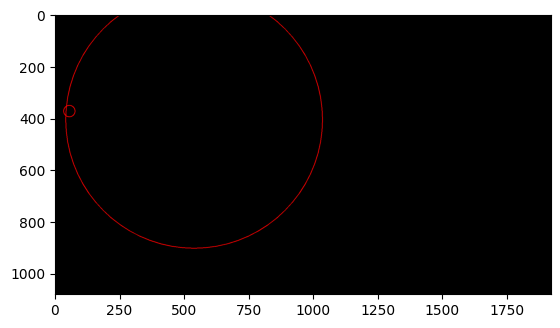

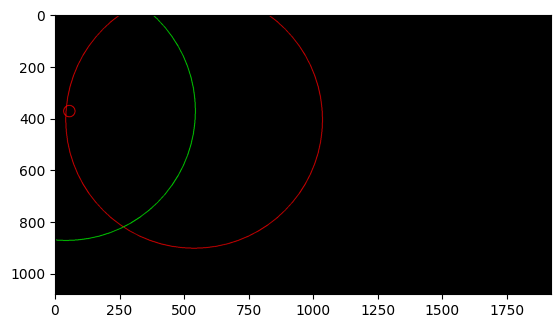

merge  0 8 (42, 373, 500) (378, 370, 123)


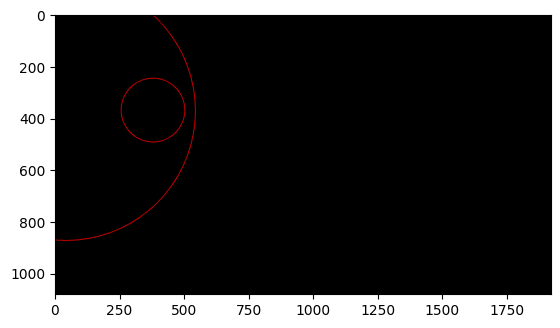

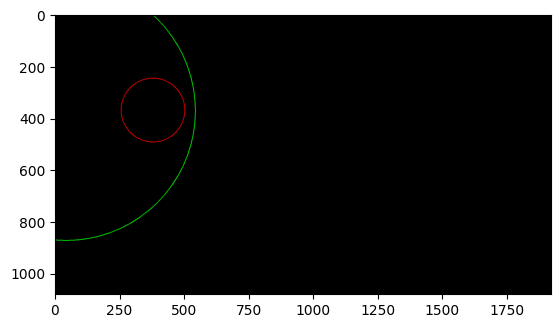

merge  0 19 (42, 373, 500) (154, 353, 103)


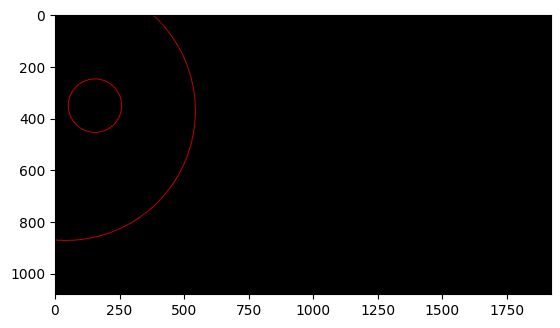

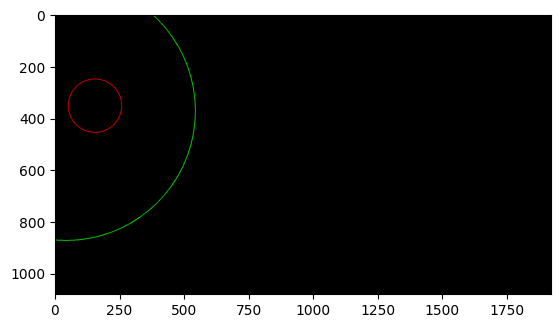

merge  0 28 (42, 373, 500) (122, 317, 33)


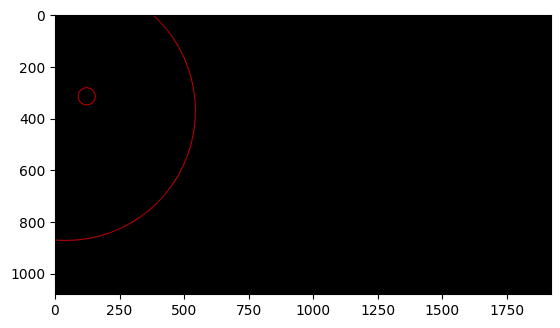

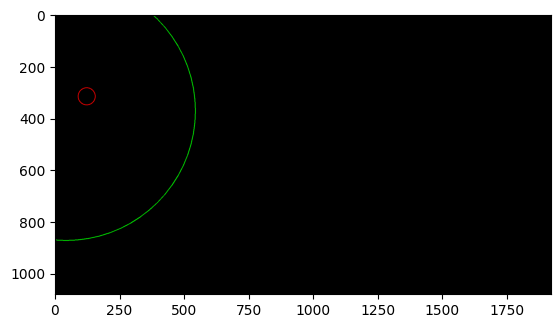

merge  0 28 (42, 373, 500) (65, 318, 26)


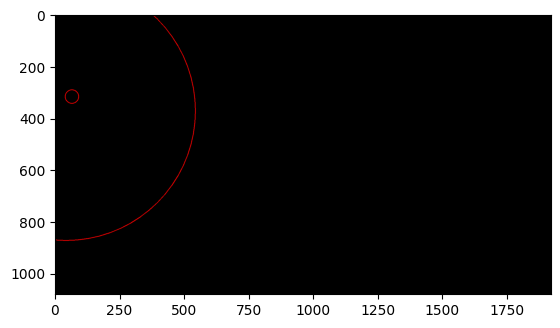

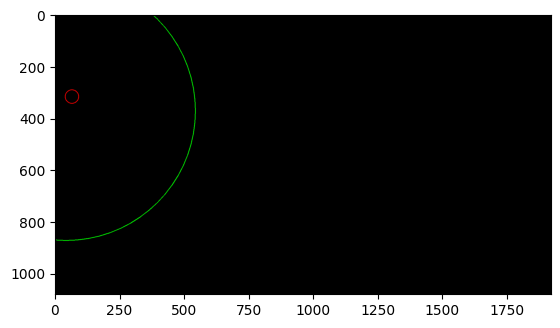

merge  0 28 (42, 373, 500) (33, 321, 48)


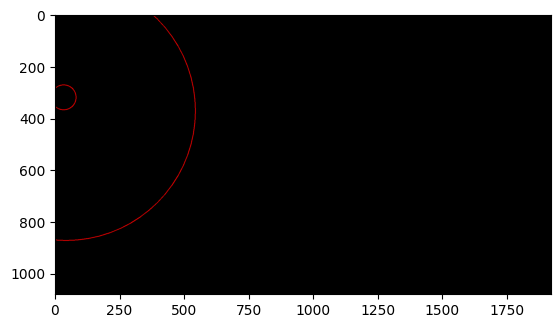

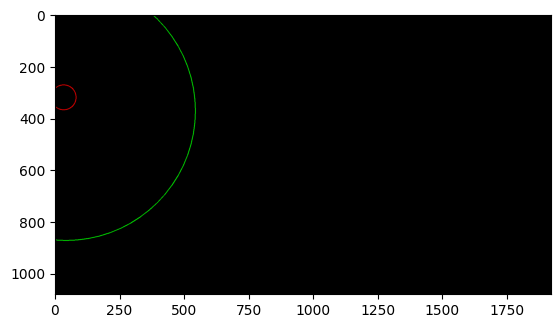

merge  0 35 (42, 373, 500) (153, 301, 19)


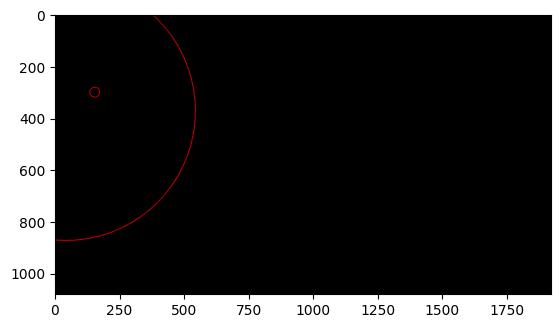

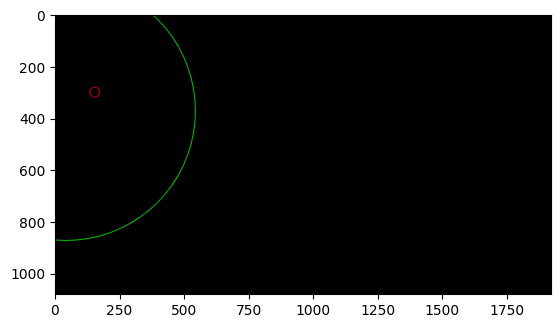

merge  0 35 (42, 373, 500) (91, 300, 24)


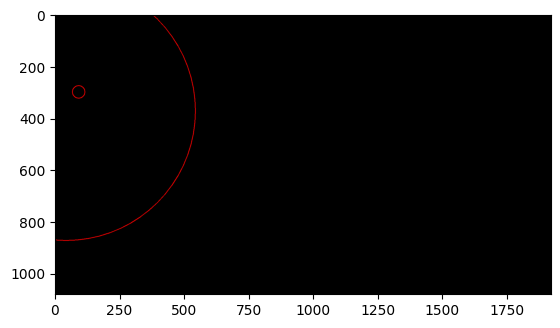

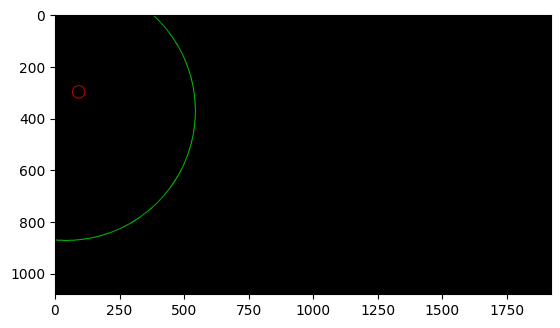

merge  0 36 (42, 373, 500) (26, 280, 39)


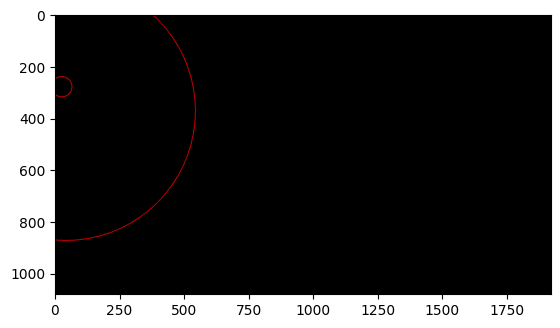

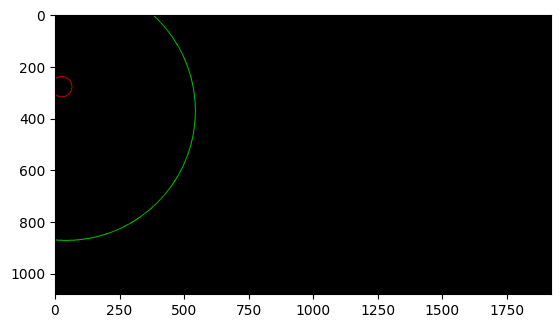

merge  0 39 (42, 373, 500) (81, 264, 18)


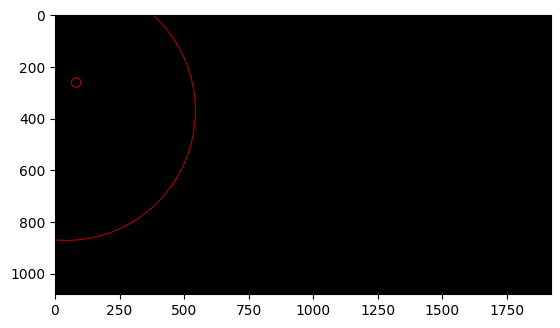

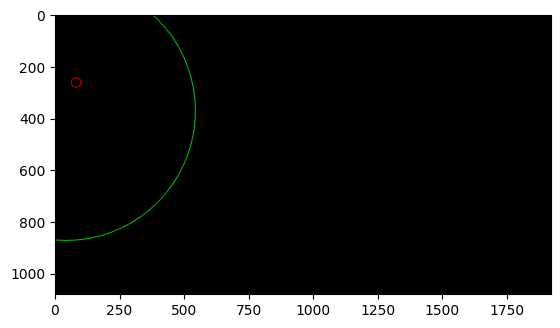

merge  0 42 (42, 373, 500) (115, 246, 31)


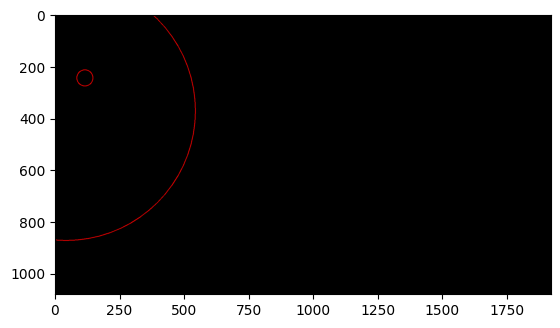

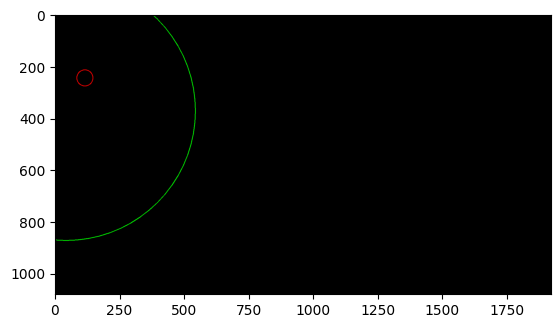

merge  0 47 (42, 373, 500) (544, 294, 123)


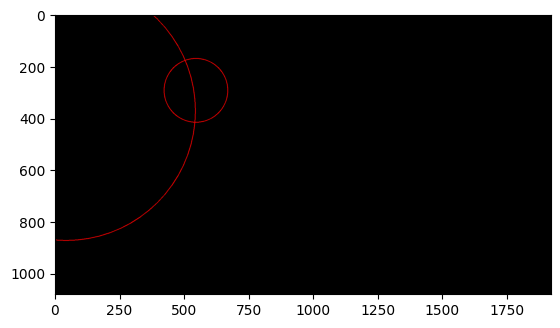

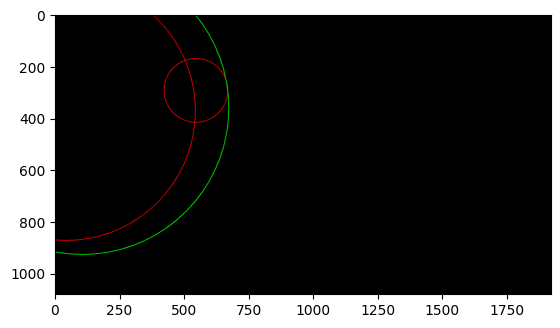

merge  0 47 (106, 362, 565) (29, 218, 18)


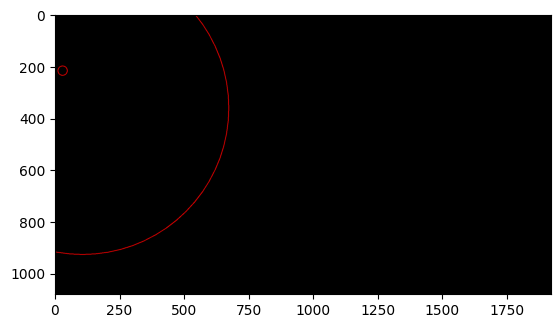

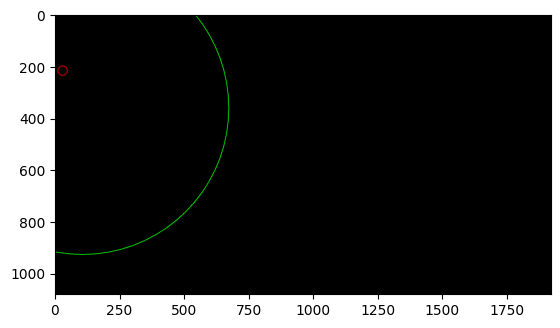

merge  0 49 (106, 362, 565) (561, 226, 49)


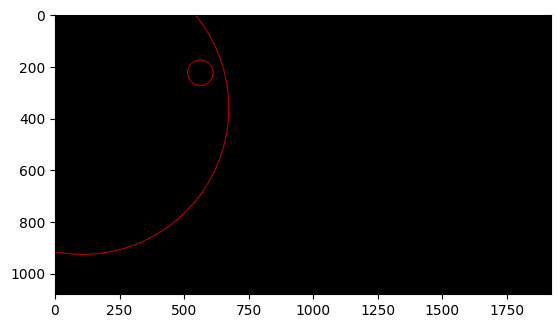

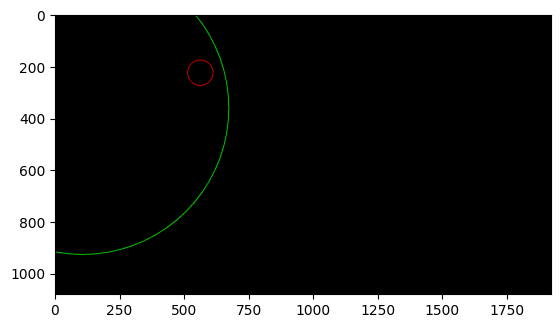

merge  0 58 (106, 362, 565) (36, 162, 49)


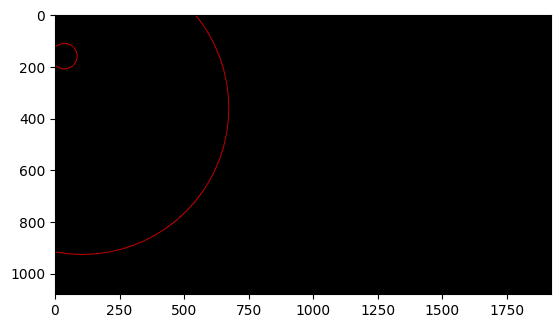

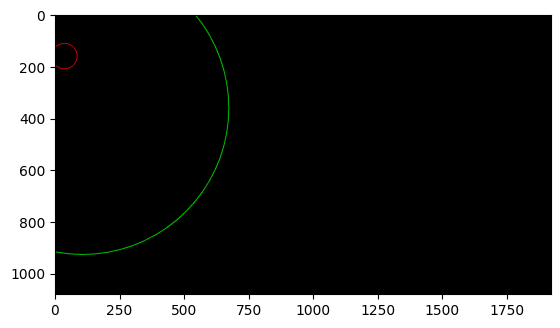

merge  0 59 (106, 362, 565) (643, 96, 147)


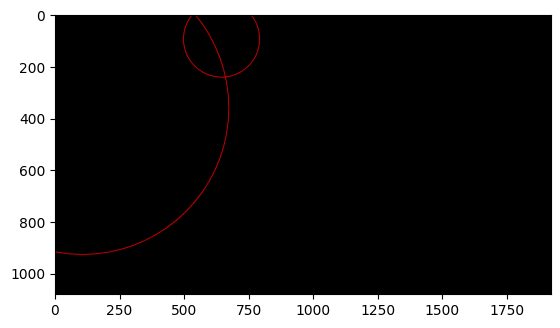

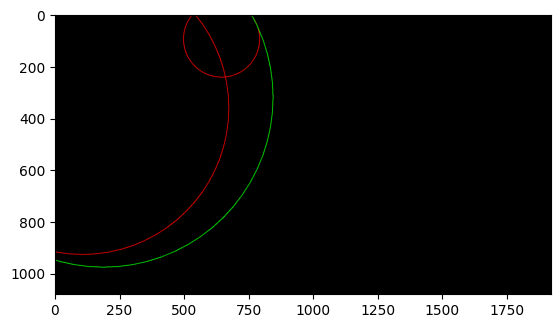

merge  0 59 (187, 321, 655) (20, 102, 36)


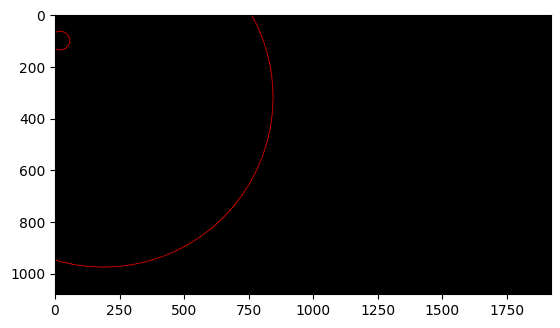

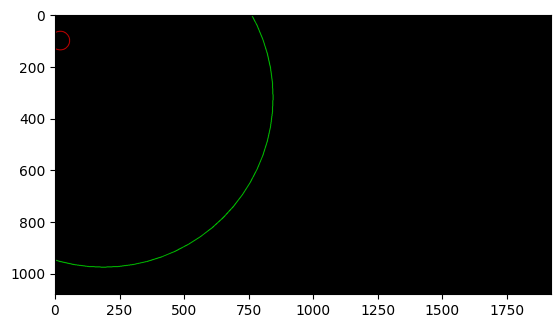

merge  0 59 (187, 321, 655) (519, 81, 18)


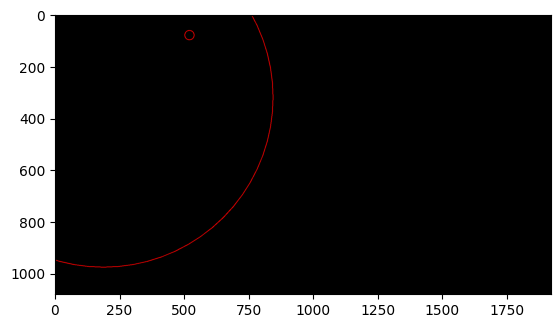

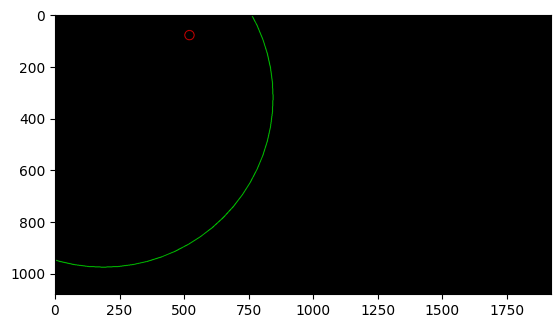

merge  0 61 (187, 321, 655) (489, 34, 51)


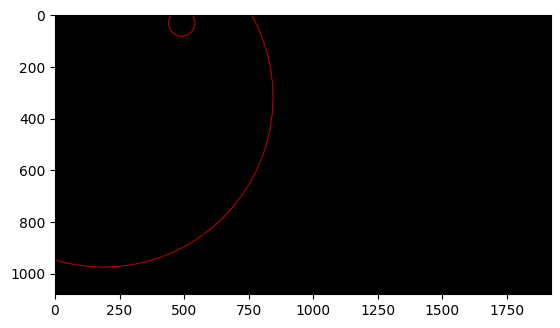

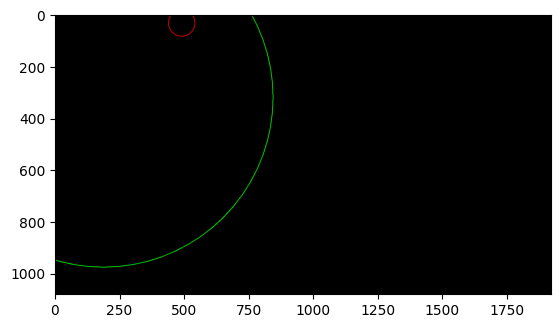

merge  2 5 (1660, 405, 19) (1619, 385, 36)


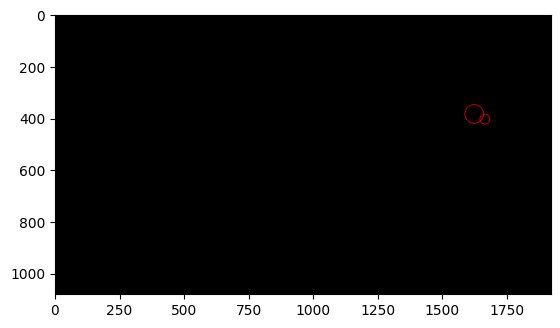

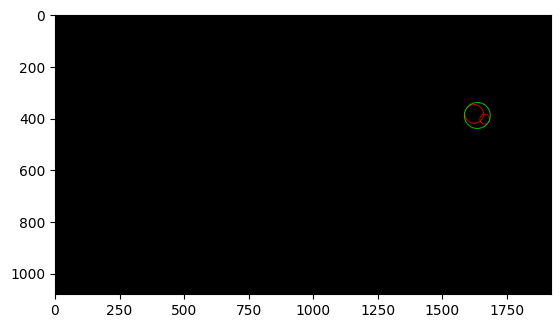

merge  2 7 (1631, 391, 50) (1648, 364, 24)


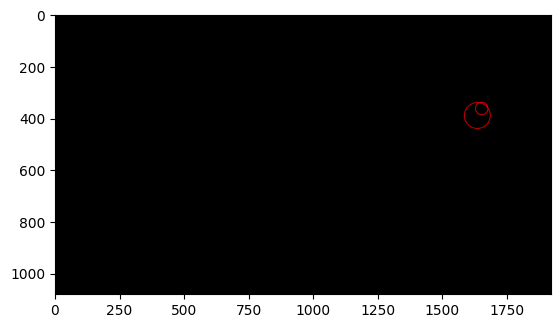

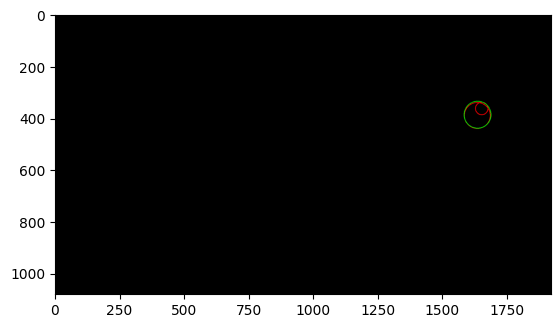

merge  2 10 (1632, 388, 52) (1572, 343, 23)


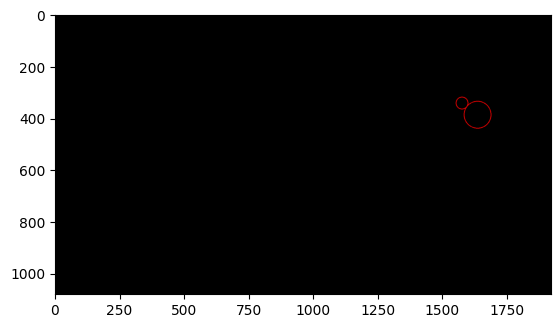

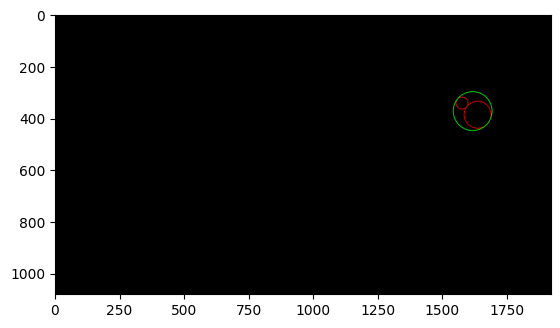

merge  2 10 (1613, 374, 75) (1606, 343, 19)


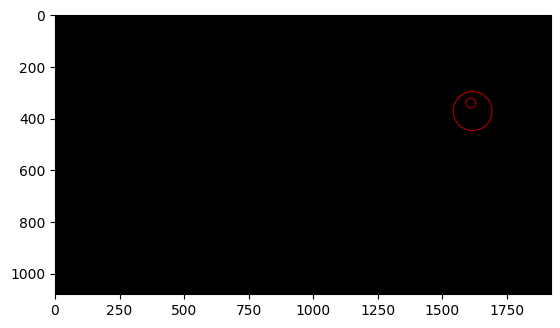

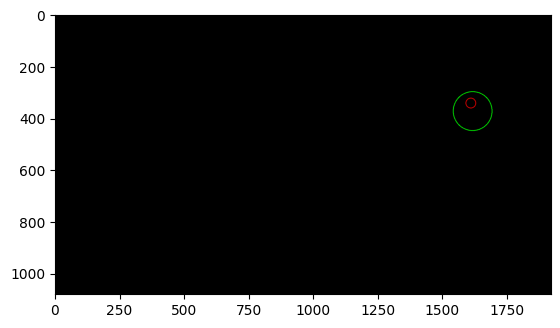

merge  2 17 (1613, 374, 75) (1696, 326, 24)


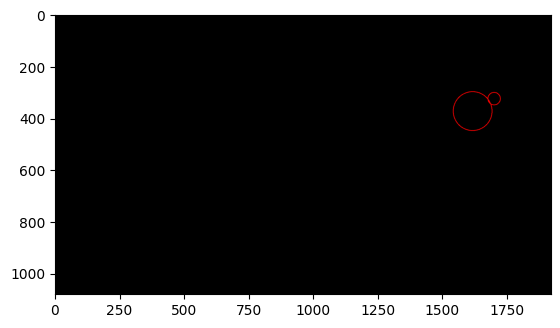

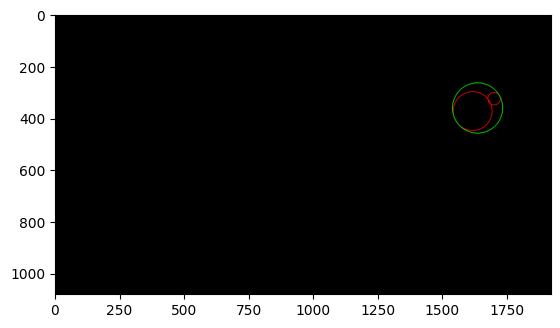

merge  2 20 (1632, 362, 97) (1647, 325, 40)


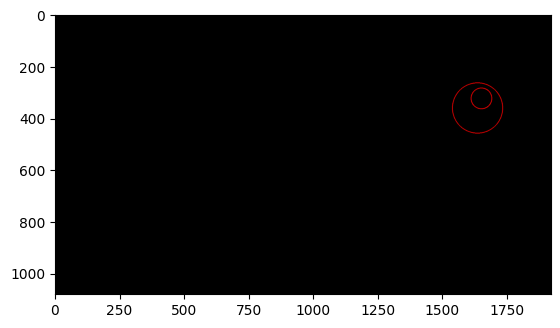

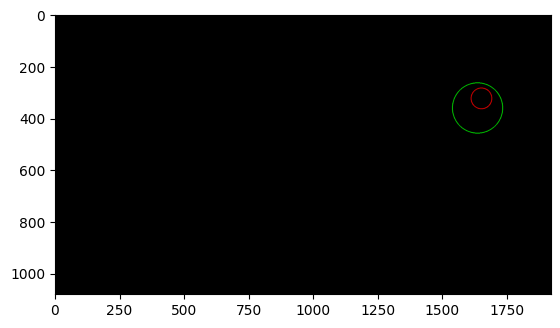

merge  2 21 (1632, 362, 97) (1522, 317, 39)


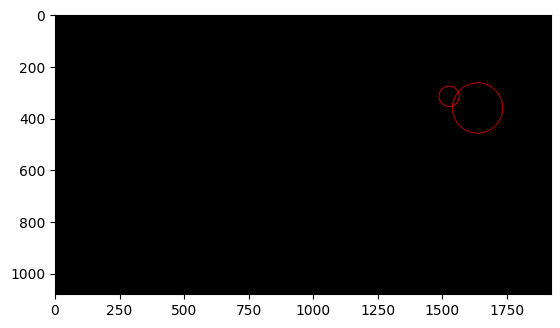

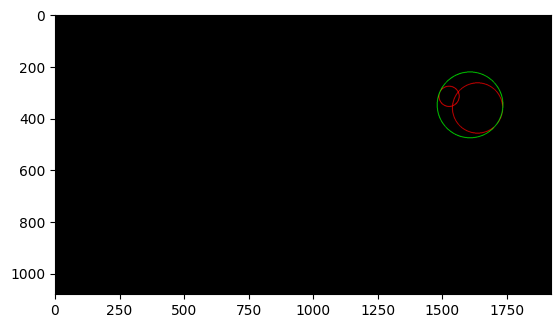

merge  2 29 (1603, 350, 127) (1791, 271, 81)


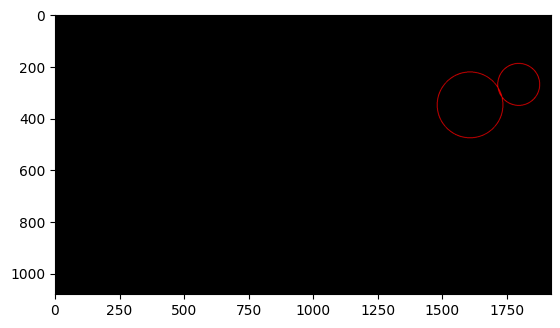

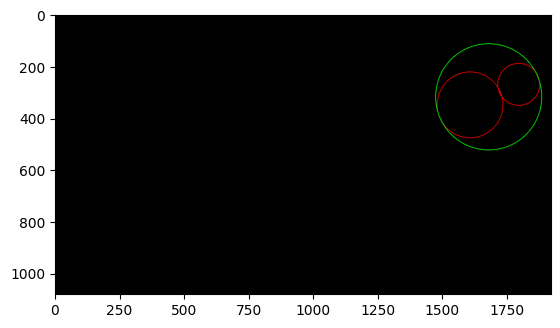

merge  2 31 (1675, 319, 205) (1842, 260, 27)


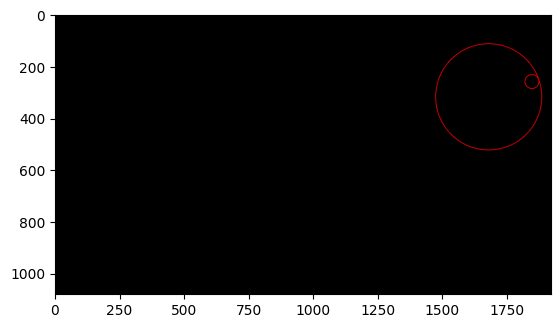

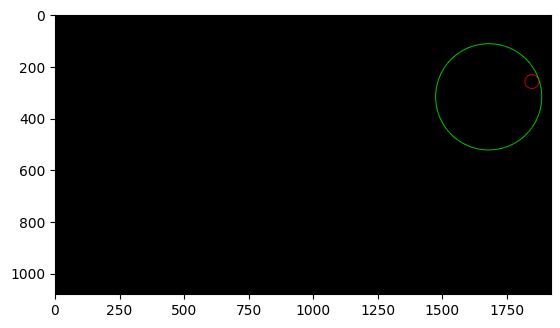

merge  2 31 (1675, 319, 205) (1782, 254, 33)


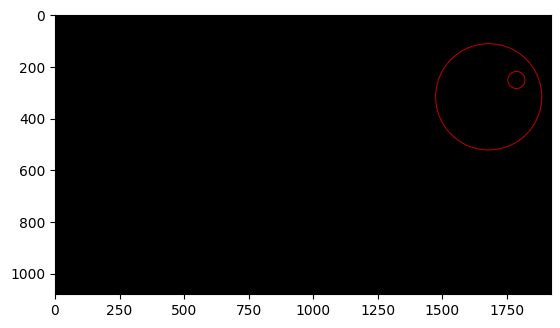

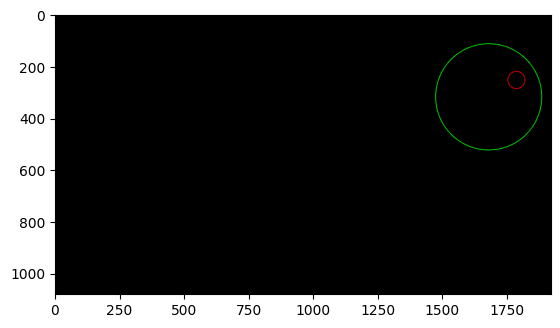

merge  2 33 (1675, 319, 205) (1792, 232, 18)


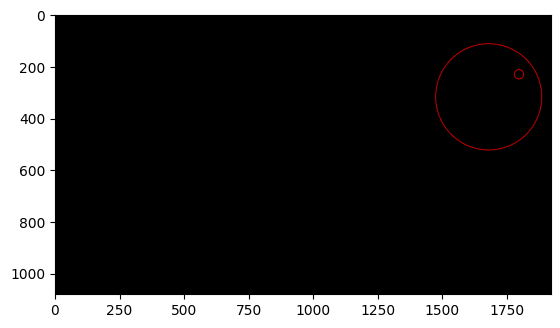

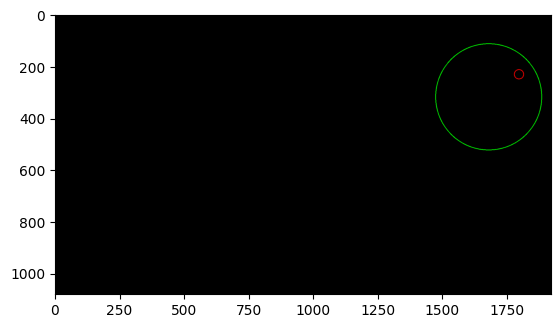

merge  2 34 (1675, 319, 205) (1763, 226, 18)


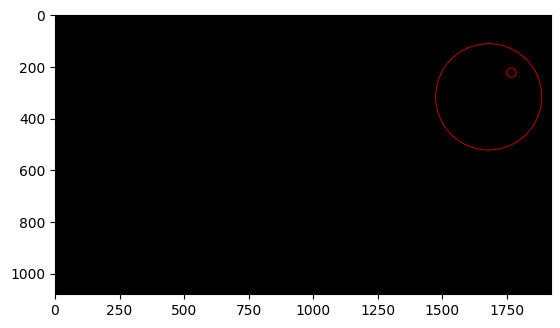

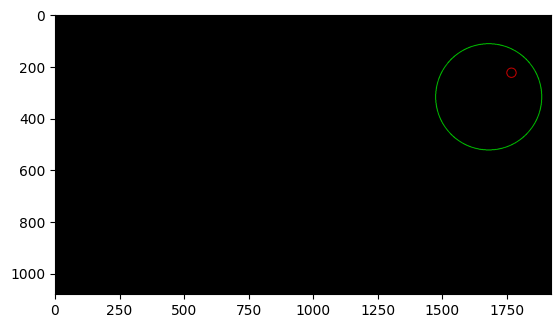

merge  2 35 (1675, 319, 205) (1854, 212, 24)


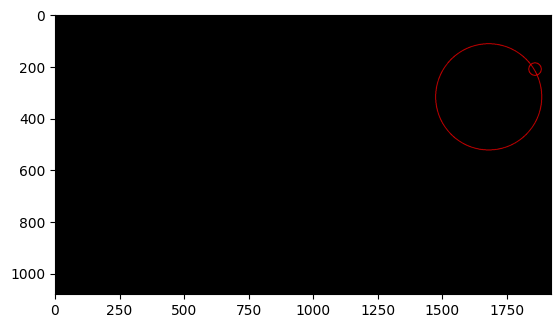

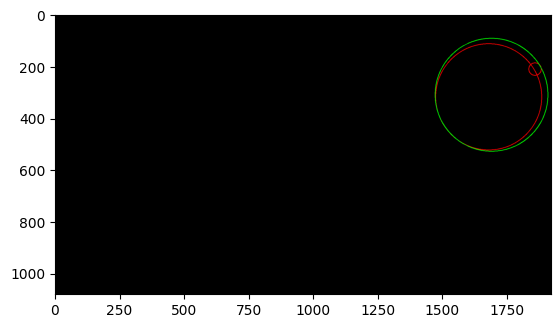

merge  2 35 (1686, 311, 218) (1814, 212, 26)


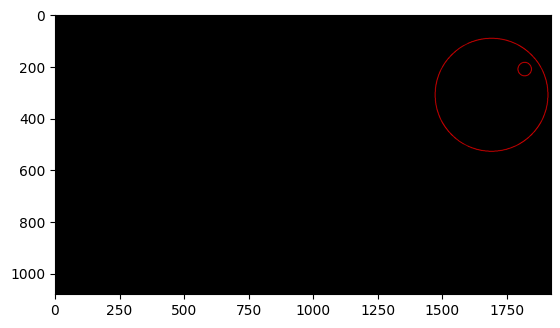

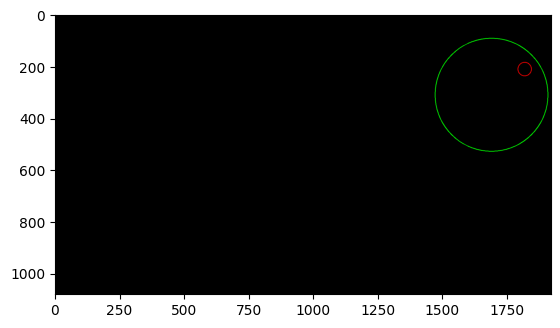

merge  2 35 (1686, 311, 218) (1846, 199, 20)


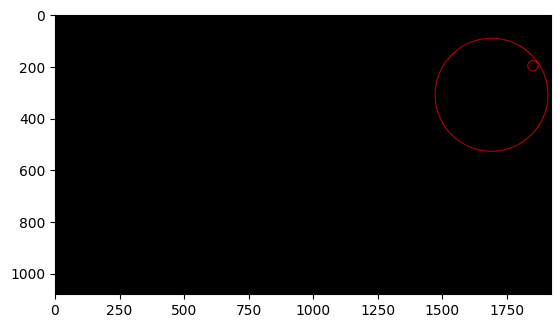

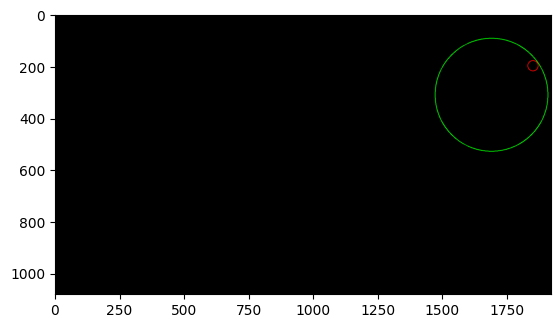

merge  2 36 (1686, 311, 218) (1897, 198, 28)


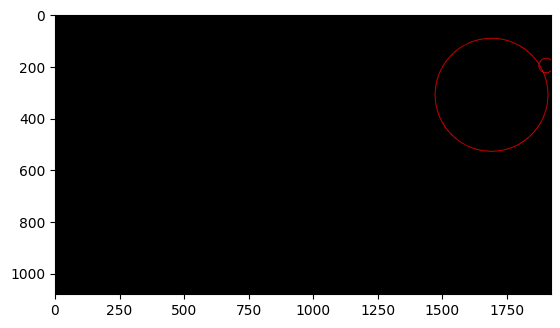

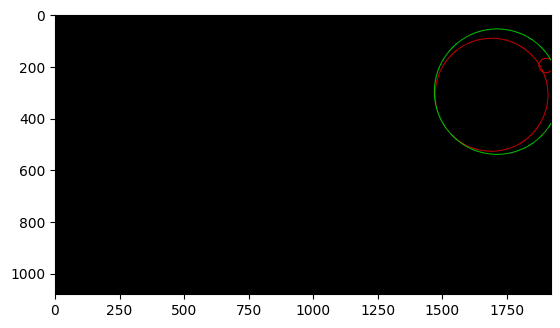

merge  2 36 (1707, 299, 242) (1870, 190, 22)


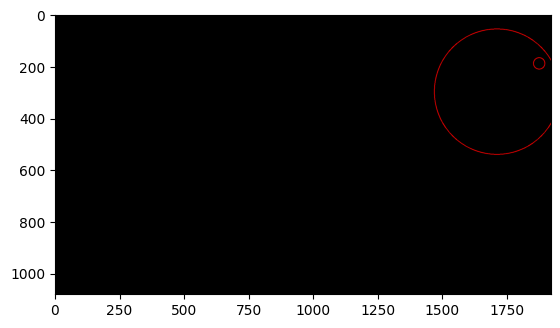

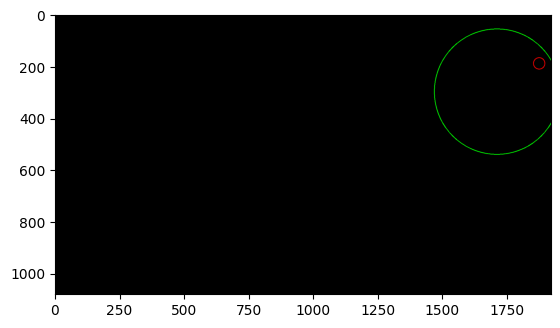

merge  2 36 (1707, 299, 242) (1902, 177, 24)


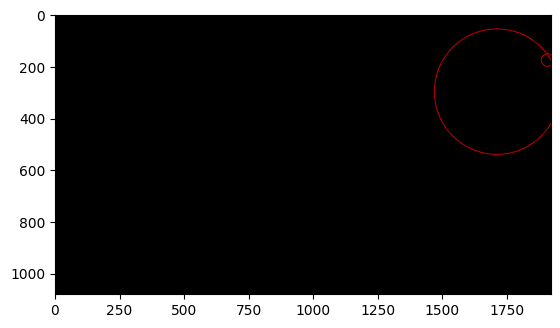

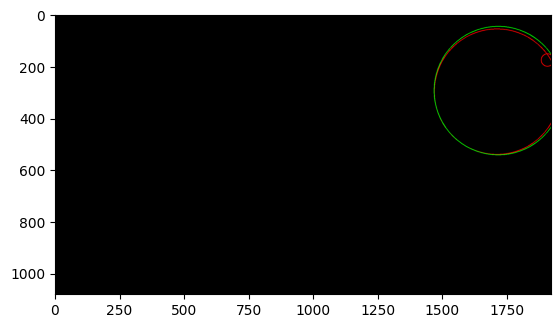

merge  2 36 (1712, 295, 248) (1776, 175, 21)


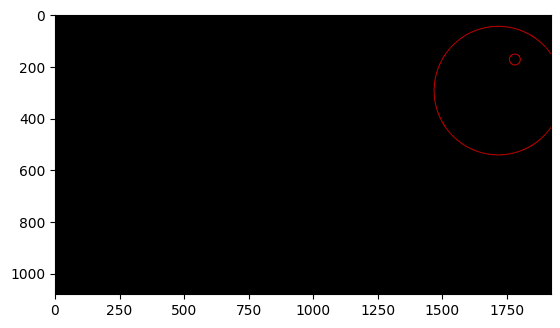

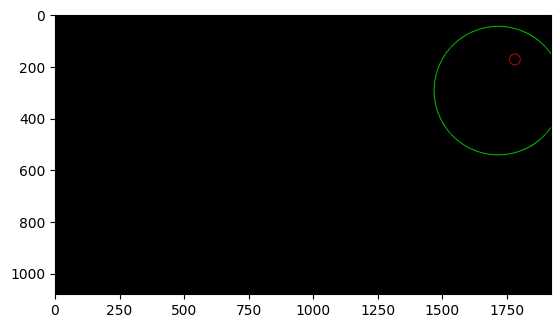

merge  2 36 (1712, 295, 248) (1851, 165, 22)


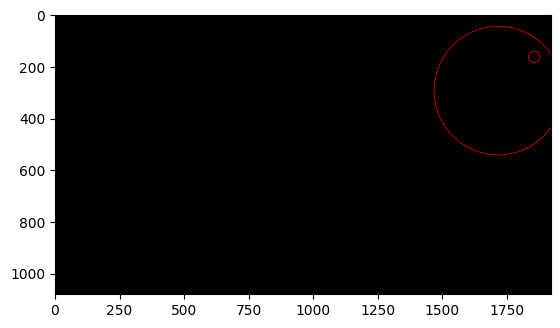

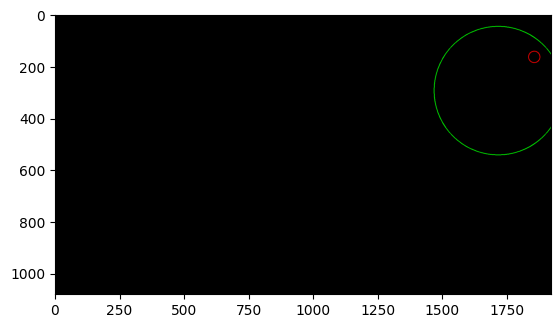

merge  2 36 (1712, 295, 248) (1891, 162, 30)


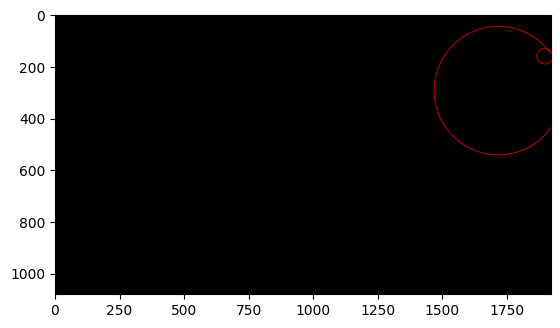

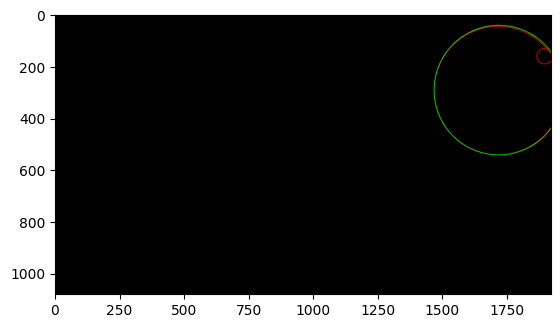

merge  2 36 (1714, 293, 250) (1862, 148, 21)


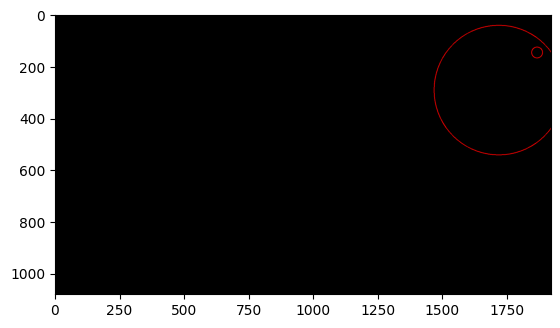

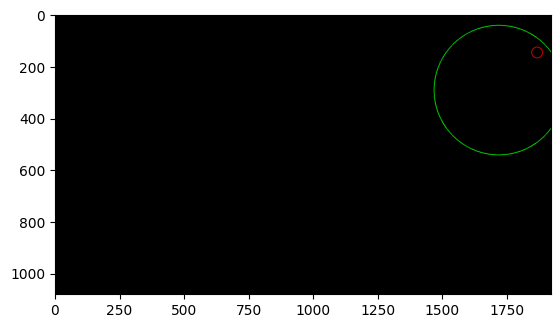

merge  4 6 (1370, 381, 21) (1419, 376, 33)


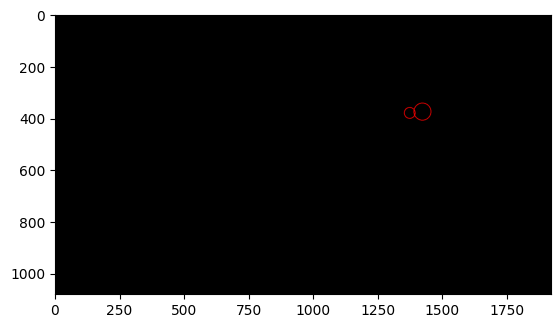

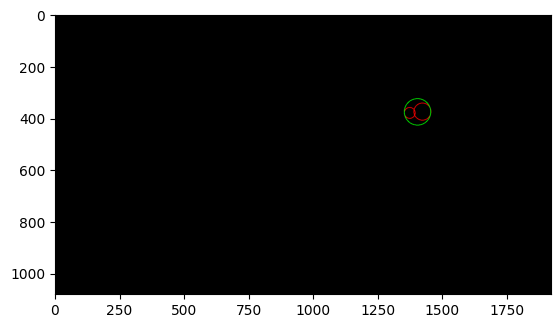

merge  4 8 (1400, 377, 51) (1343, 359, 41)


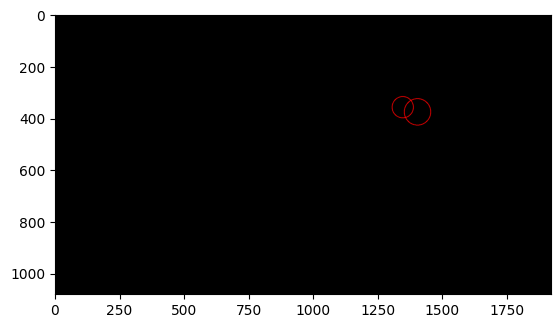

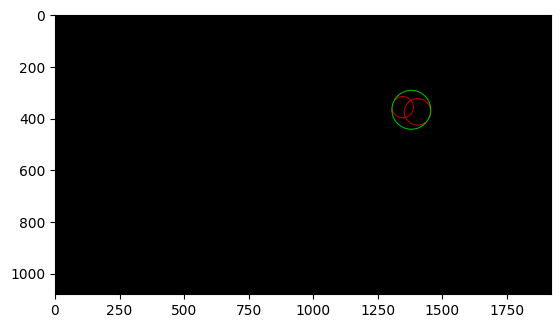

merge  4 8 (1376, 369, 75) (1466, 342, 19)


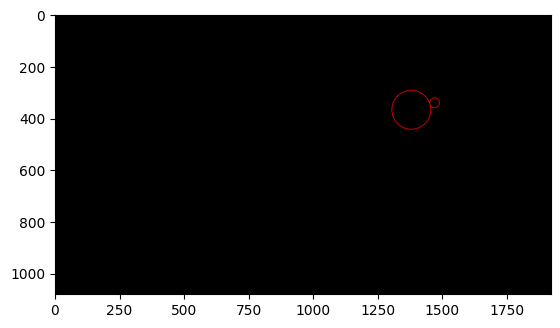

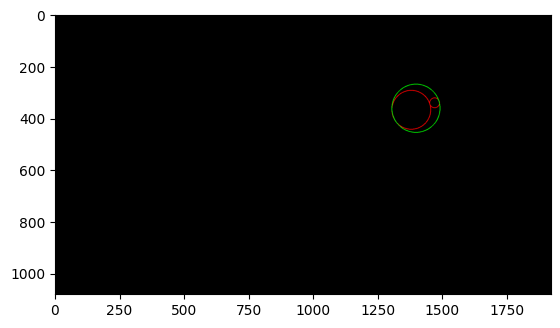

merge  4 13 (1394, 363, 93) (1363, 331, 32)


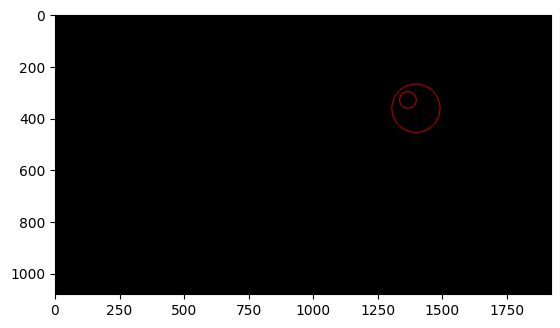

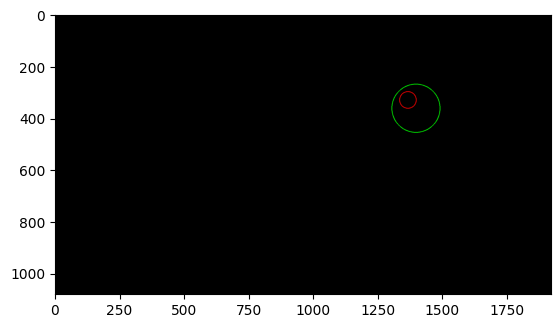

merge  4 13 (1394, 363, 93) (1408, 332, 24)


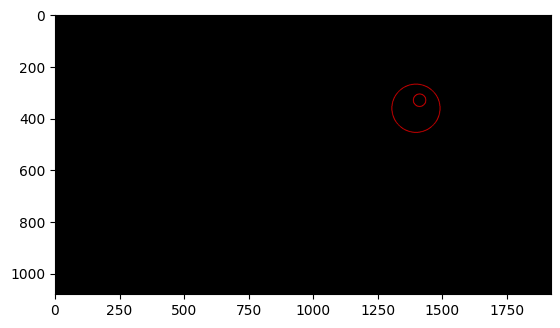

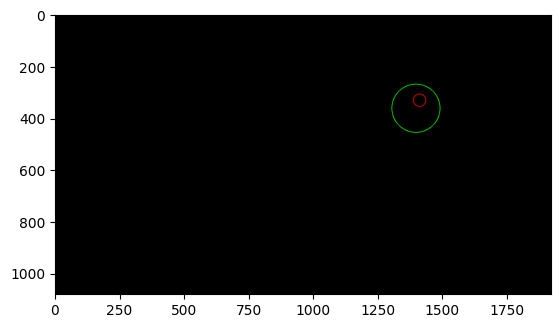

merge  4 14 (1394, 363, 93) (1452, 324, 60)


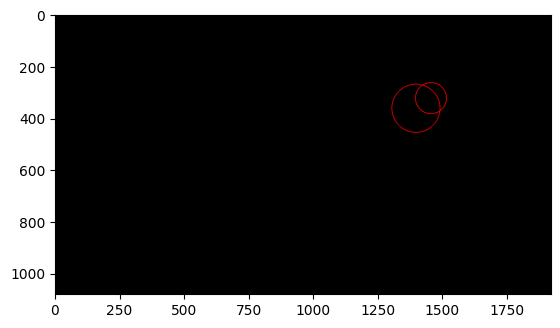

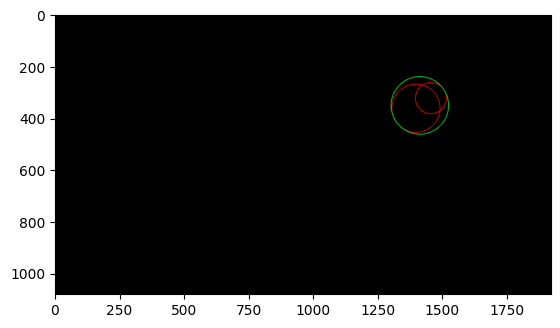

merge  4 19 (1409, 352, 111) (1370, 301, 21)


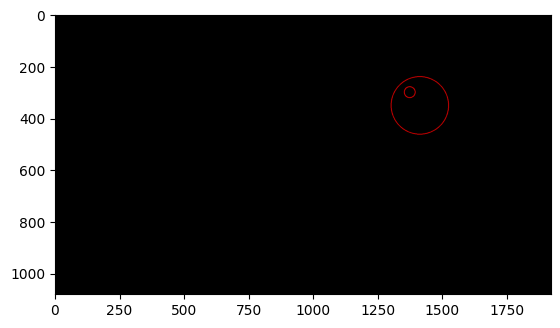

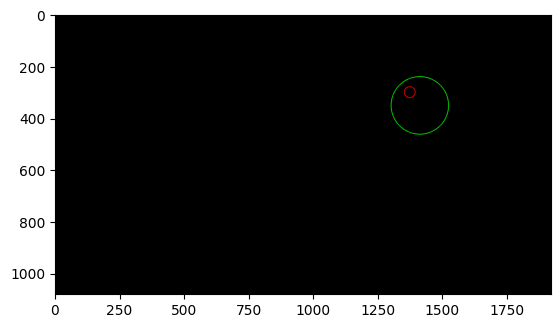

merge  4 19 (1409, 352, 111) (1304, 313, 41)


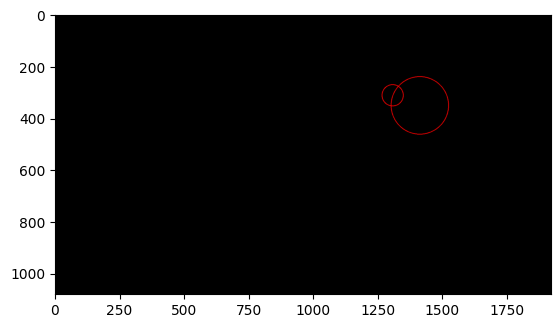

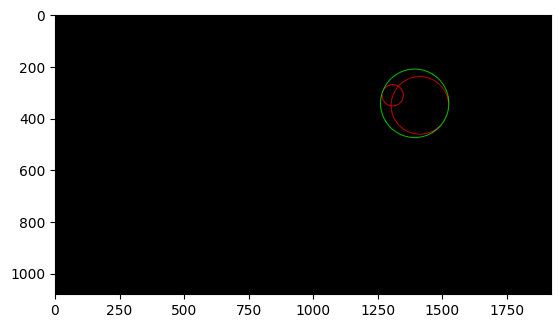

merge  5 9 (1172, 374, 18) (1177, 344, 45)


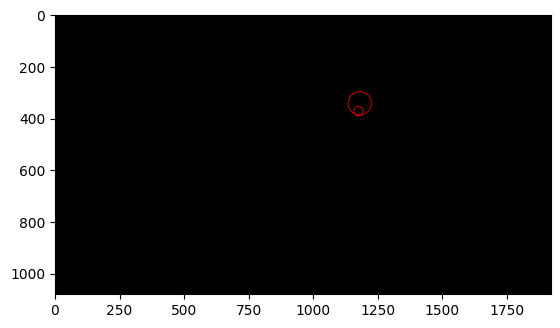

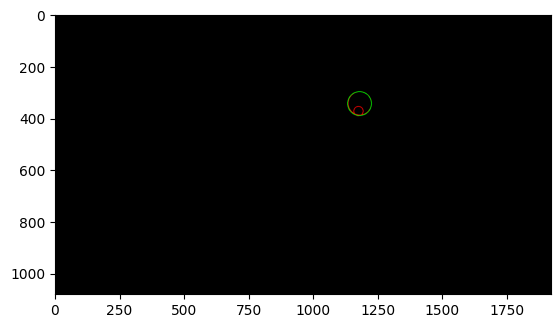

merge  5 17 (1176, 345, 46) (1138, 302, 21)


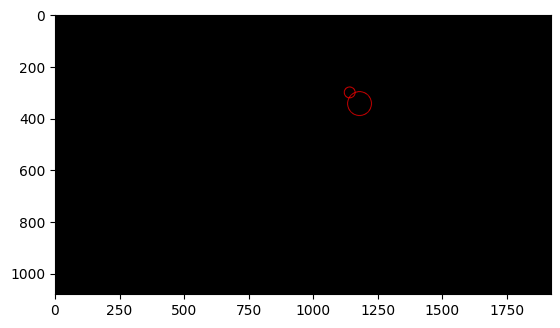

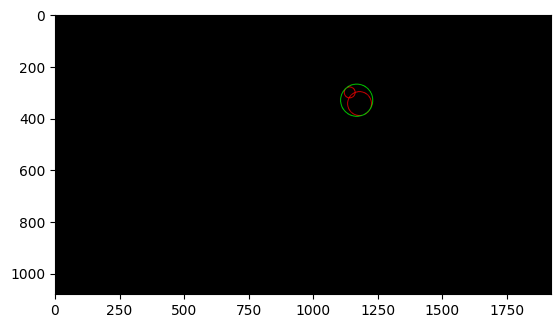

merge  5 17 (1165, 332, 62) (1184, 304, 21)


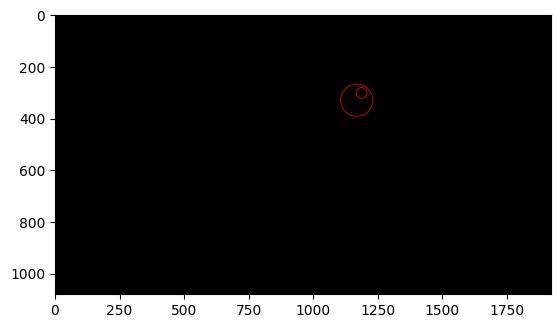

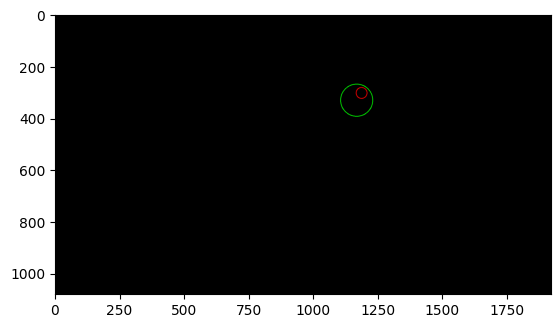

merge  7 8 (1057, 362, 22) (814, 366, 265)


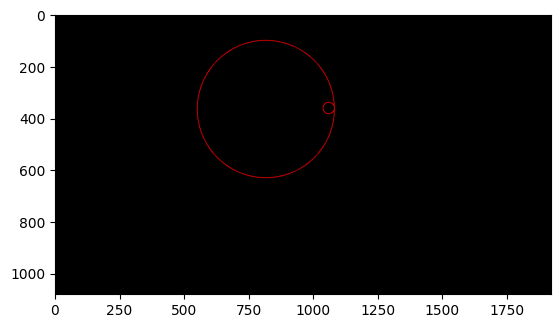

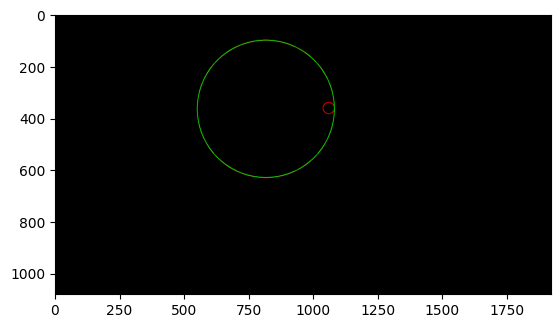

merge  7 13 (814, 365, 265) (1065, 320, 37)


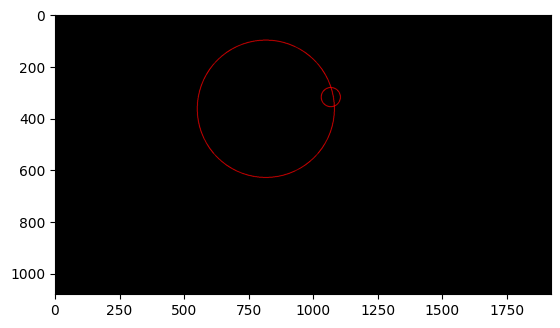

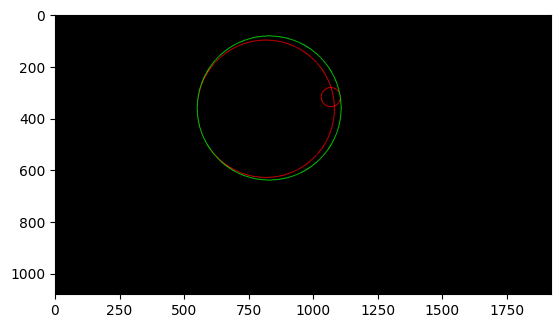

merge  7 14 (827, 362, 278) (1108, 306, 21)


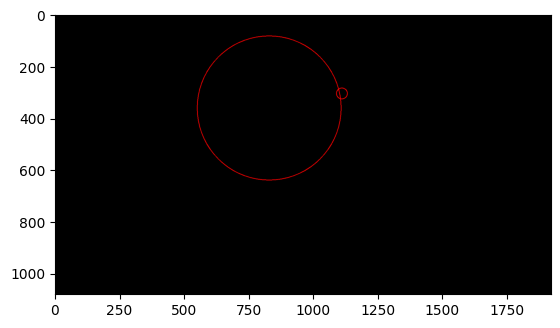

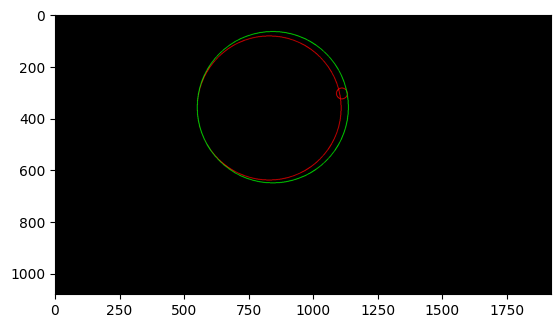

merge  7 14 (841, 359, 292) (594, 296, 35)


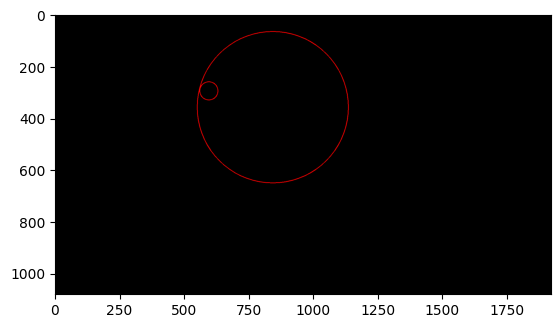

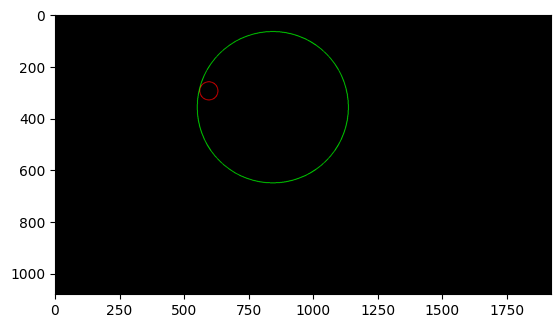

merge  7 14 (841, 359, 292) (615, 294, 57)


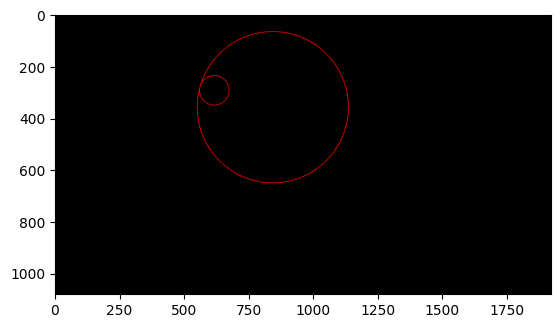

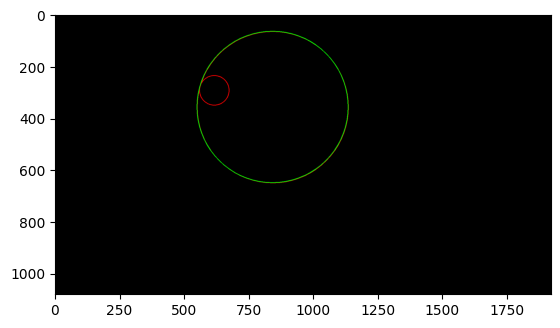

merge  7 14 (840, 358, 292) (1059, 260, 27)


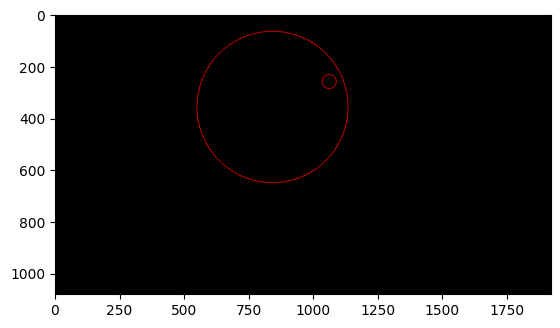

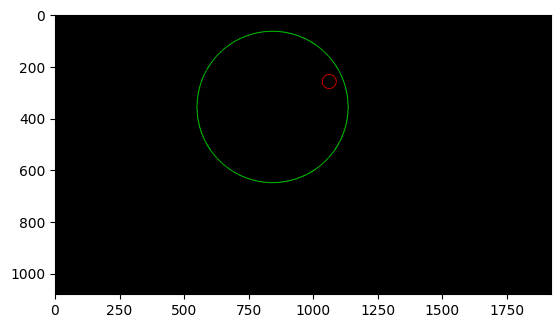

merge  7 14 (840, 358, 292) (569, 255, 21)


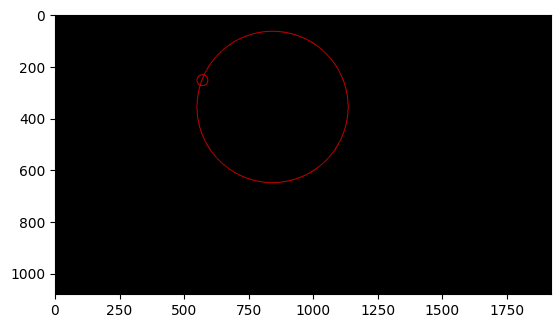

KeyboardInterrupt: 

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, nsolve
import numpy as np
from scipy.optimize import fsolve


def show_circles(image, circles, color):
    for i, circle in enumerate(circles):
        x, y, r = circle
        cv2.circle(image, (x, y), r, color, 2)
        cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Center
        cv2.putText(image, f"{i}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    plt.imshow(image);
    plt.show()

def circles_intersect(circle1, circle2):
    # Check if two circles intersect
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    dist_centers = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist_centers <= (r1 + r2), dist_centers

def circle_in_circle(circle1, circle2, dist_centers):
    # Check if circle1 is inside circle2
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    if dist_centers + r2 <= r1:
        return circle1
    if dist_centers + r1 <= r2:
        return circle2
    else:
        return False
    
def find_new_center(circle1, circle2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2

    # Symbole
    x, y = symbols('x y')

    # Prosta przechodząca przez 2 punkty
    m = (y2 - y1) / (x2 - x1)
    line_eq = Eq(y - y1, m*(x - x1))

    # Równanie okręgu: (x - a)^2 + (y - b)^2 = r^2
    circle_eq1 = Eq((x - x1)**2 + (y - y1)**2, r1**2)
    circle_eq2 = Eq((x - x2)**2 + (y - y2)**2, r2**2)

    # Rozwiązanie równań
    solutions1 = solve((line_eq, circle_eq1), (x, y))
    solutions2 = solve((line_eq, circle_eq2), (x, y))
    solutions = solutions1 + solutions2

    solutions.sort(key=lambda p: p[0] + p[1])

    x = (solutions[0][0] + solutions[-1][0])//2
    y = (solutions[0][1] + solutions[-1][1])//2



    # # Line equation: ax + by + c = 0
    # m = (y2 - y1) / (x2 - x1)
    # a = m
    # b = -1
    # c = -m * x1 + y1

    # # Define functions
    # def line_equation(x):
    #     return a * x[0] + b * x[1] + c

    # def circle1_equation(x):
    #     return (x[0] - x1)**2 + (x[1] - y1)**2 - r1**2

    # # Initial guess for the intersection point
    # initial_guess = [0, 0]

    # # Use fsolve to find the intersection
    # intersection = fsolve(lambda x: [line_equation(x), circle1_equation(x)], initial_guess)

    # print("Intersection Point:", intersection)


    return (int(x), int(y))
   


def show_merge(image, center1, r1, center2, r2, new_center, new_radius):
    blank = np.zeros_like(image)
    # blank = image.copy()

    cv2.circle(blank, center1, r1, (255, 0, 0), 2)
    cv2.circle(blank, center2, r2, (255, 0, 0), 2)
    cv2.circle(blank, new_center, new_radius, (0, 255, 0), 2)
    plt.imshow(blank);
    plt.show()


# Create a black image
image_with_merges = np.zeros_like(image)
# image = np.zeros((300, 400, 3), dtype=np.uint8)

# Initialize the list of circles
# circles = [
#     (130, 140, 20),
#     (150, 150, 30),
#     (150, 175, 25),
#     (300, 100, 35),
#     (310, 110, 10)
# ]
show_circles(image_with_merges, circles, (0, 255, 0))


# Greedy grouping algorithm to merge intersecting circles
changed = True
while changed == True:
    changed = False
    i = 0
    while i < len(circles):
            j = i + 1
            while j < len(circles):
                intersect, distance = circles_intersect(circles[i], circles[j])
                x1, y1, r1 = circles[i]
                x2, y2, r2 = circles[j]
                if intersect:
                    # Merge circles[i] and circles[j]
                    print("merge ", i, j, circles[i], circles[j])
                    show_merge(image_with_merges, (x1, y1), r1, (x2, y2), r2, (0,0), 0)

                    if circle:= circle_in_circle(circles[i], circles[j], distance):
                        new_x, new_y, new_radius = circle
                    else:
                        new_radius = int((r1 + r2 + distance)//2)
                        new_x, new_y = find_new_center(circles[i], circles[j])
                    
                    show_merge(image_with_merges, (x1, y1), r1, (x2, y2), r2, (new_x, new_y), new_radius)
                    circles[i] = (new_x, new_y, new_radius)
                    circles.pop(j)
                    changed = True

                else:
                    j+=1
            i += 1
                    
# Draw circles around the final merged circles
show_circles(image_with_merges, circles, (255, 0 , 0))


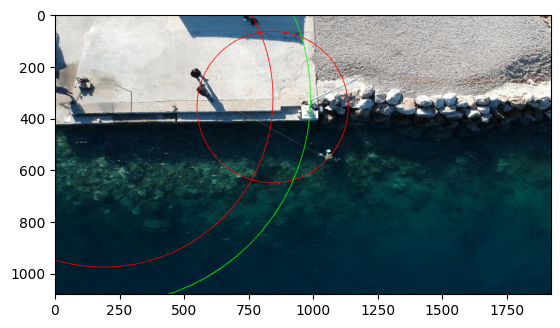

In [63]:
circle1 = (187, 321, 655)
circle2 = (840, 358, 292)
intersect, distance = circles_intersect(circle1, circle2)
x1, y1, r1 = circle1
x2, y2, r2 = circle2
new_radius = int((r1 + r2 + distance)//2)
# new_x, new_y = find_new_center(circle1, circle2)
# image_merge = image.copy()
show_merge(image, (x1, y1), r1, (x2, y2), r2, (x1, y1), new_radius)

In [33]:
set(old_circles) - set(circles)

{(157, 412, 24), (258, 602, 18), (322, 412, 213), (561, 409, 134)}

# Get labels

In [26]:
def draw_circles(image, circles, color):
    # show all circles on the image
    for i, circle in enumerate(circles):
        x, y, r = circle
        cv2.circle(image, (x, y), r, color, 2)
        cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Center
        cv2.putText(image, f"{i}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return image

In [27]:
path = "data/Dataset/training/"
filename = "train_image1"
image = io.imread(path + filename + ".JPG")

trash_rectangles = []

with open(path + filename + ".json") as json_file:
    data = json.load(json_file)
    shapes = data["shapes"]
    print(shapes)

    for shape in shapes: 
        if shape["shape_type"] != "rectangle": raise Exception("Invalid shape type")
        if shape["label"] != "trash": raise Exception("Invalid label")
        
        bl, tr = shape["points"]
        bl = tuple(map(int, bl))
        tr = tuple(map(int, tr))

        trash_rectangles.append((bl, tr))

trash_rectangles

[{'label': 'trash', 'points': [[678.5714285714286, 510.71428571428567], [898.2142857142857, 703.5714285714286]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}}]


[((678, 510), (898, 703))]

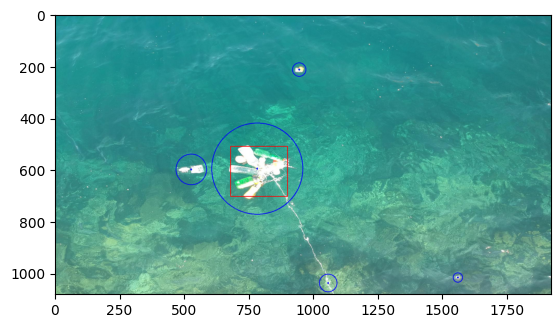

In [28]:
image_labels = image.copy()
draw_circles(image_labels, circles, (0, 0, 255))
for xy, wh in trash_rectangles:
    cv2.rectangle(image_labels, xy, wh, (255, 0, 0), 2)

plt.imshow(image_labels);

In [29]:
from shapely.geometry import Point, Polygon

def intersection_over_union(circle, rectangle):
    x, y, r = circle
    bl, tr = rectangle
    rectangle_corners = [bl, (bl[0], tr[1]), tr, (tr[0], bl[1])]

    circle = Point((x, y)).buffer(r)
    rectangle = Polygon(rectangle_corners)
    
    intersection_area = circle.intersection(rectangle).area
    union_area = circle.union(rectangle).area
    
    iou = intersection_area / union_area
    
    return 0 if union_area == 0 else iou

In [30]:
trash_circles = []

for rectangle in trash_rectangles:
    for i, circle in enumerate(circles):
        if intersection_over_union(circle, rectangle) > 0.3:
            print("trash detected")
            trash_circles.append(i)

false_circles = [circle for i, circle in enumerate(circles) if i not in trash_circles]
    

trash detected


## Convert circles to rectangles

In [31]:
false_rectangles = []
for circle in false_circles:
    x, y, r = circle
    false_rectangles.append(((x-r, y-r), (x+r, y+r)))

len(false_rectangles), len(trash_rectangles)

(4, 1)

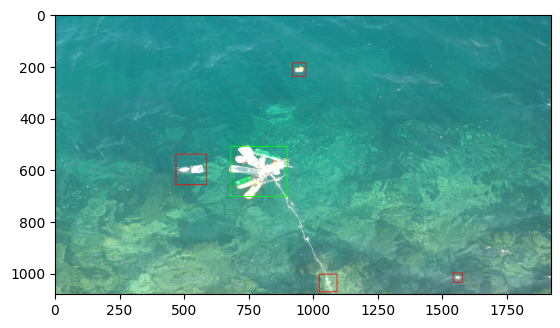

In [32]:
image_labels = image.copy()
for bl, tr in trash_rectangles:
    cv2.rectangle(image_labels, bl, tr, (0, 255, 0), 2)

for bl, tr in false_rectangles:
    cv2.rectangle(image_labels, bl, tr, (255, 0, 0), 2)


plt.imshow(image_labels);

In [37]:
trash_rectangles

[((678, 510), (898, 703))]

678 898 510 703


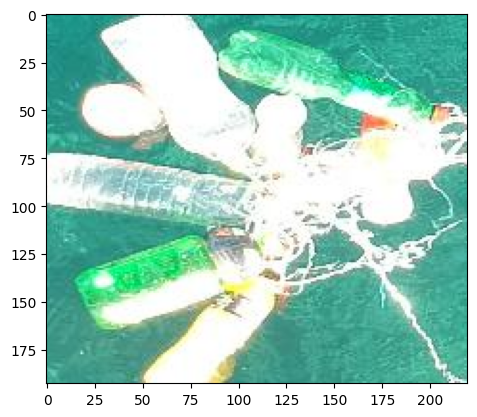

In [42]:
plt.imshow(image[ trash_rectangles[0][0][1]: trash_rectangles[0][1][1], trash_rectangles[0][0][0]: trash_rectangles[0][1][0]])

print(trash_rectangles[0][0][0], trash_rectangles[0][1][0], trash_rectangles[0][0][1], trash_rectangles[0][1][1])

# SIFT and histograms

 SIFT descriptor to create gradient histograms
 HOG 
 - feture extraction 
 - 

In [21]:
from skimage.feature import hog
from skimage import exposure


fd, hog_image = hog(dog_image, visualize=True, block_norm='L2-Hys')

# fd, hog_image = hog(dog_image, orientations=8, pixels_per_cell=(16, 16),
                    # cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(dog_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

NameError: name 'dog_image' is not defined

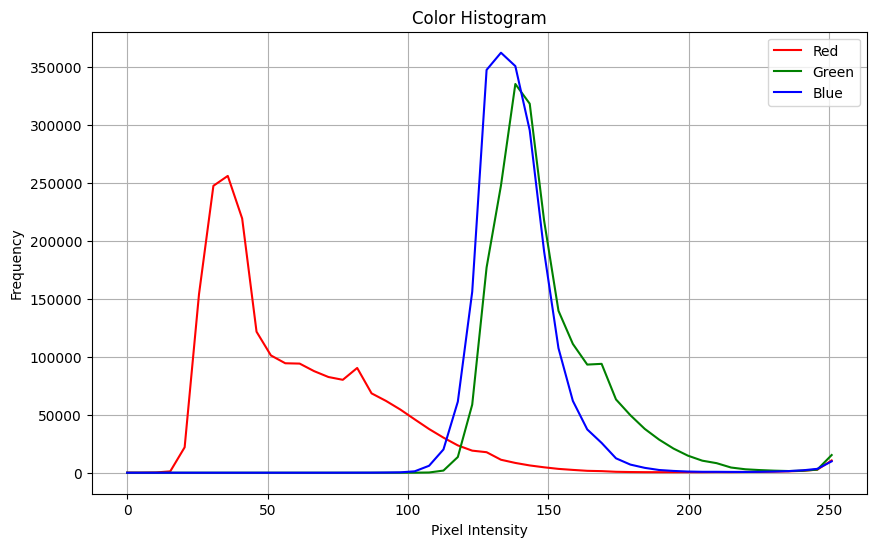

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# Step 1: Read the input image
image = io.imread('Dataset/training/train_image1.JPG')

# Step 2: Compute color histograms for each channel (R, G, B)
hist_r, bins_r = np.histogram(image[:, :, 0], bins=50, range=(0, 256))
hist_g, bins_g = np.histogram(image[:, :, 1], bins=50, range=(0, 256))
hist_b, bins_b = np.histogram(image[:, :, 2], bins=50, range=(0, 256))

# Step 3: Plot the color histograms
plt.figure(figsize=(10, 6))
plt.plot(bins_r[:-1], hist_r, color='r', label='Red')
plt.plot(bins_g[:-1], hist_g, color='g', label='Green')
plt.plot(bins_b[:-1], hist_b, color='b', label='Blue')
plt.title('Color Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


# TODO: SVM